In [56]:
%%capture
!pip install transformers

In [57]:
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from torch import nn
from torch.optim import Adam
from tqdm import tqdm
import re

In [58]:
datapath = f'/content/spam.csv'
df = pd.read_csv(datapath)
df.isnull().values.any()
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


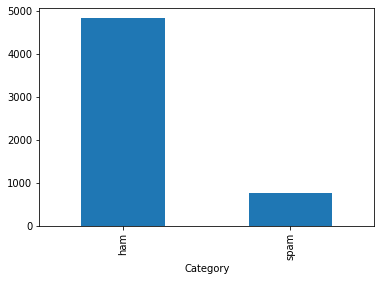

In [59]:
df.groupby(['Category']).size().plot.bar()

In [60]:
df.loc[:,"Message"]

0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                 Will ü b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: Message, Length: 5572, dtype: object

In [61]:
def preprocess_text(sen):

    sentence = remove_tags(sen)
    #print(sentence) 

    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    #print(sentence)

    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    #print(sentence)

    sentence = re.sub(r'\s+', ' ', sentence)
    #print(sentence)

    return sentence

In [62]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [63]:
Message = []
sentences = list(df['Message'])
for sen in sentences:
  Message.append(preprocess_text(sen))



In [64]:
counter = 0
for sen in Message:
    df.loc[counter, ['Message']] = [sen]
    counter+=1

In [65]:
print(df.columns.values)

['Category' 'Message']


In [66]:
df.head(20)

,Category,Message
0,ham,Go until jurong point crazy Available only in ...
1,ham,Ok lar Joking wif oni
2,spam,Free entry in wkly comp to win FA Cup final tk...
3,ham,U dun say so early hor c already then say
4,ham,Nah don think he goes to usf he lives around h...
5,spam,FreeMsg Hey there darling it been week now and...
6,ham,Even my brother is not like to speak with me T...
7,ham,As per your request Melle Melle Oru Minnaminun...
8,spam,WINNER As valued network customer you have bee...
9,spam,Had your mobile months or more R entitled to U...


In [67]:
df_spam = df[df['Category']=='spam']

In [68]:
df_ham = df[df['Category']=='ham']

In [69]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0]) # to reduce no. of ham.

In [70]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])

In [71]:
df_balanced['Category'].value_counts()

ham     747
spam    747
Name: Category, dtype: int64

In [72]:
df_balanced['spam']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)

In [73]:
df_balanced.sample(10)

,Category,Message,spam
3460,spam,Not heard from a while Call me now am here all...,1
3126,spam,st wk FREE Gr tones str each wk Txt NOKIA ON ...,1
1811,ham,Now whats your house again And do you have any...,0
3818,ham,This is my number by vivek,0
54,spam,SMS ac Sptv The New Jersey Devils and the Detr...,1
4076,ham,God picked up flower and dippeditinaDEW loving...,0
3243,ham,Good Morning my Dear Have great amp successful...,0
1500,spam,SMS ac JSco Energy is high but may not know wh...,1
3294,ham,A little Meds say take once every hours It onl...,0
3889,ham,ok take care umma to you too,0


In [74]:
df = df_balanced

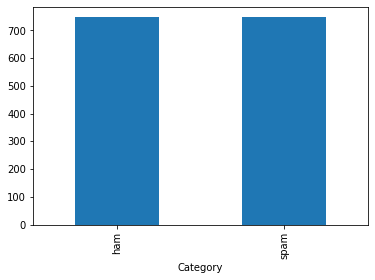

In [75]:
df.groupby(['Category']).size().plot.bar()

In [76]:
from sklearn.model_selection import train_test_split

In [77]:
X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'],df_balanced['spam'], stratify=df_balanced['spam'])

In [78]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {'spam':1,
          'ham':0
          }

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['Category']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['Message']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [90]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.2):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [80]:
def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:
                   
                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} | Train Accuracy: {total_acc_train / len(train_data): .3f} | Val Loss: {total_loss_val / len(val_data): .3f} | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  

In [81]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')


In [89]:
my_data = {
    'Category' : ['ham'],
    'Message' : ['You can win a lot of money, register in the link below'],
    'spam' : [0]
}
df = pd.DataFrame(my_data)
test = Dataset(df)
test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
if use_cuda:
    model = model.cuda()
total_acc_test = 0
with torch.no_grad():
    for test_input, test_label in test_dataloader:
          test_label = test_label.to(device)
          mask = test_input['attention_mask'].to(device)
          input_id = test_input['input_ids'].squeeze(1).to(device)
          output = model(input_id, mask)
          print(output.argmax(dim=1).data)
          print(test_label)

tensor([0], device='cuda:0')
tensor([0], device='cuda:0')


In [86]:
output.argmax(dim=1)

tensor([0], device='cuda:0')

In [29]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

1195 149 150


In [83]:
df_test

,Category,Message,spam
3515,ham,I always chat with you In fact need money can ...,0
919,ham,Hey you gave them your photo when you register...,0
1942,spam,WELL DONE Your Costa Del Sol Holiday or await ...,1
1854,ham,I just made some payments so dont have that mu...,0
3895,spam,Dear Dave this is your final notice to collect...,1
...,...,...,...
2808,spam,December only Had your mobile mths You are ent...,1
4073,spam,Loans for any purpose even if you have Bad Cre...,1
784,spam,You have an important customer service announc...,1
5278,spam,URGENT Your Mobile number has been awarded wit...,1


In [91]:
EPOCHS = 10

model = BertClassifier()
LR = 1e-6       

train(model, df_train, df_val, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 598/598 [02:09<00:00,  4.61it/s]


Epochs: 1 | Train Loss:  0.528 | Train Accuracy:  0.800 | Val Loss:  0.262 | Val Accuracy:  0.973


100%|██████████| 598/598 [02:10<00:00,  4.60it/s]


Epochs: 2 | Train Loss:  0.159 | Train Accuracy:  0.967 | Val Loss:  0.104 | Val Accuracy:  0.960


100%|██████████| 598/598 [02:10<00:00,  4.60it/s]


Epochs: 3 | Train Loss:  0.060 | Train Accuracy:  0.987 | Val Loss:  0.061 | Val Accuracy:  0.980


100%|██████████| 598/598 [02:09<00:00,  4.60it/s]


Epochs: 4 | Train Loss:  0.030 | Train Accuracy:  0.994 | Val Loss:  0.048 | Val Accuracy:  0.973


100%|██████████| 598/598 [02:09<00:00,  4.60it/s]


Epochs: 5 | Train Loss:  0.016 | Train Accuracy:  0.997 | Val Loss:  0.044 | Val Accuracy:  0.980


100%|██████████| 598/598 [02:09<00:00,  4.60it/s]


Epochs: 6 | Train Loss:  0.010 | Train Accuracy:  0.997 | Val Loss:  0.054 | Val Accuracy:  0.980


100%|██████████| 598/598 [02:09<00:00,  4.61it/s]


Epochs: 7 | Train Loss:  0.006 | Train Accuracy:  0.999 | Val Loss:  0.050 | Val Accuracy:  0.980


100%|██████████| 598/598 [02:09<00:00,  4.60it/s]


Epochs: 8 | Train Loss:  0.004 | Train Accuracy:  1.000 | Val Loss:  0.045 | Val Accuracy:  0.980


100%|██████████| 598/598 [02:09<00:00,  4.60it/s]


Epochs: 9 | Train Loss:  0.003 | Train Accuracy:  0.999 | Val Loss:  0.049 | Val Accuracy:  0.980


100%|██████████| 598/598 [02:09<00:00,  4.60it/s]


Epochs: 10 | Train Loss:  0.003 | Train Accuracy:  1.000 | Val Loss:  0.048 | Val Accuracy:  0.980


In [34]:
sup = 'You can win a lot of money, register in the link below'

In [38]:
df_test

,Category,Message,spam
3515,ham,I always chat with you In fact need money can ...,0
919,ham,Hey you gave them your photo when you register...,0
1942,spam,WELL DONE Your Costa Del Sol Holiday or await ...,1
1854,ham,I just made some payments so dont have that mu...,0
3895,spam,Dear Dave this is your final notice to collect...,1
...,...,...,...
2808,spam,December only Had your mobile mths You are ent...,1
4073,spam,Loans for any purpose even if you have Bad Cre...,1
784,spam,You have an important customer service announc...,1
5278,spam,URGENT Your Mobile number has been awarded wit...,1


In [39]:
evaluate(model2,df_test)

Test Accuracy:  0.927


In [92]:
 torch.save(model.state_dict(), '/content/weights.pth')

In [32]:
model2 = BertClassifier()
model2.load_state_dict(torch.load('/content/weights.pth'))
model2.eval()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru